<a href="https://colab.research.google.com/github/HikariJadeEmpire/AudioBook_DATAEngineering/blob/main/S02_DATACleansing_Spark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# In this file, I will :

Clean the data using PySpark, follow the steps below:
- Data profiling
- EDA
- Anomaly Detection with PySpark
- Export

First, we will prepare the necessary tools.

In [ ]:
!apt-get update                                                                           # Update all Package in this VM
!apt-get install openjdk-8-jdk-headless -qq > /dev/null                                   # install Java Development Kit (Spark requires this)
!wget -q https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz  # install Spark 3.1.2
!tar xzvf spark-3.1.2-bin-hadoop2.7.tgz                                                   # Unzip Spark 3.1.2
!pip install -q findspark==1.3.0                                                          # To connect with Spark, install the required Python package.

In [1]:
# To make Python recognize Spark, set the environment variable.
import os

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop2.7"

In [2]:
! ls

drive  sample_data  spark-3.1.2-bin-hadoop2.7  spark-3.1.2-bin-hadoop2.7.tgz


In [5]:
# Install PySpark to Python

!pip install pyspark==3.1.2

In [6]:
# Check the Google Colab server's core. (cpu cores)

!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0xffffffff
cpu MHz		: 2200.166
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa mmio_stale_data retbleed
bogomips	: 4400.33
clflush size	: 64
cache_alignment	: 64
addres

In [2]:
# Create Spark Session

from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").getOrCreate()

To perform a multi-core operation and utilize all available CPU cores using Spark, we use ```local[*]```

In [4]:
import sys

print(f'Python version : {sys.version}\nSpark version : {spark.version}')

Python version : 3.10.12 (main, Jun  7 2023, 12:45:35) [GCC 9.4.0]
Spark version : 3.1.2


# DATA Profiling

In [3]:
df = spark.read.csv('/content/drive/MyDrive/myColab_Notebooks/myData.csv', header = True, inferSchema = True, )

## Tips
To convert Pandas dataframe to Spark dataframe :

```
sparkDF = spark.createDataFrame(pandasDF)

```

In [6]:
df.show()

+-------------------+--------+--------+--------------------+--------+--------------------+--------------------+------------------+-------------------+------------------+--------------------+--------------------+------+--------------------+-----+---------------+------------------+
|          timestamp| user_id|book_id2|             country|Book_ID4|          Book Title|       Book Subtitle|       Book Author|      Book Narrator|     Audio Runtime|      Audiobook_Type|          Categories|Rating|Total No. of Ratings|Price|conversion_rate|         THB_Price|
+-------------------+--------+--------+--------------------+--------+--------------------+--------------------+------------------+-------------------+------------------+--------------------+--------------------+------+--------------------+-----+---------------+------------------+
|2021-05-01 00:00:01|ad8eca41|    1584|            Portugal|    1584|        Sycamore Row|                null|      John Grisham|       Michael Beck|20 hrs 

In [11]:
df.dtypes

[('timestamp', 'string'),
 ('user_id', 'string'),
 ('book_id2', 'int'),
 ('country', 'string'),
 ('Book_ID4', 'int'),
 ('Book Title', 'string'),
 ('Book Subtitle', 'string'),
 ('Book Author', 'string'),
 ('Book Narrator', 'string'),
 ('Audio Runtime', 'string'),
 ('Audiobook_Type', 'string'),
 ('Categories', 'string'),
 ('Rating', 'string'),
 ('Total No. of Ratings', 'double'),
 ('Price', 'double'),
 ('conversion_rate', 'double'),
 ('THB_Price', 'double')]

In [12]:
df.printSchema()

root
 |-- timestamp: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- book_id2: integer (nullable = true)
 |-- country: string (nullable = true)
 |-- Book_ID4: integer (nullable = true)
 |-- Book Title: string (nullable = true)
 |-- Book Subtitle: string (nullable = true)
 |-- Book Author: string (nullable = true)
 |-- Book Narrator: string (nullable = true)
 |-- Audio Runtime: string (nullable = true)
 |-- Audiobook_Type: string (nullable = true)
 |-- Categories: string (nullable = true)
 |-- Rating: string (nullable = true)
 |-- Total No. of Ratings: double (nullable = true)
 |-- Price: double (nullable = true)
 |-- conversion_rate: double (nullable = true)
 |-- THB_Price: double (nullable = true)



In [13]:
# Count Row & column
print( (df.count(), len(df.columns)) )

(1998821, 17)


In [14]:
df.describe().show()

+-------+-------------------+--------+-----------------+-------+-----------------+-------------------------------------+--------------------+-------------+--------------------+--------------+--------------------+--------------------+-------------------+--------------------+------------------+------------------+------------------+
|summary|          timestamp| user_id|         book_id2|country|         Book_ID4|                           Book Title|       Book Subtitle|  Book Author|       Book Narrator| Audio Runtime|      Audiobook_Type|          Categories|             Rating|Total No. of Ratings|             Price|   conversion_rate|         THB_Price|
+-------+-------------------+--------+-----------------+-------+-----------------+-------------------------------------+--------------------+-------------+--------------------+--------------+--------------------+--------------------+-------------------+--------------------+------------------+------------------+------------------+
|  c

## Select columns

In [4]:
from pyspark.sql import functions as F

# F command is funtions in SQL
# in SQL : SELECT column_name1 AS new_column_name, column_name2 FROM df

df = df.select( F.col("timestamp"), F.col("user_id"),
               F.col("book_id2").alias("book_id"),
                F.col("Rating").alias("rating"),
                F.col('`Total No. of Ratings`').alias("rating_counts"),
                F.col("Categories").alias("categories"),
                F.col('`Audio Runtime`').alias("audio_runtime"),
                F.col('Audiobook_Type').alias("audiobook_type"),
                F.col("country"), F.col("Price"), F.col("THB_Price") )
df.show()

+-------------------+--------+-------+------+-------------+--------------------+------------------+--------------------+--------------------+-----+------------------+
|          timestamp| user_id|book_id|rating|rating_counts|          categories|     audio_runtime|      audiobook_type|             country|Price|         THB_Price|
+-------------------+--------+-------+------+-------------+--------------------+------------------+--------------------+--------------------+-----+------------------+
|2021-05-01 00:00:01|ad8eca41|   1584|   4.6|      25863.0|Mystery, Thriller...|20 hrs and 46 mins|Unabridged Audiobook|            Portugal| 35.0|            1089.9|
|2021-05-01 00:00:03|561b26c1|    829|   4.8|       2441.0|Relationships, Pa...| 5 hrs and 48 mins|Unabridged Audiobook|United States of ...|19.59|          610.0326|
|2021-05-01 00:00:04|81f149e5|   1391|   4.6|      26781.0|Mystery, Thriller...|11 hrs and 50 mins|Unabridged Audiobook|               Japan| 31.5|            980.91

In [17]:
df.summary("count").show()

+-------+---------+-------+-------+-------+-------------+----------+-------------+--------------+-------+-------+---------+
|summary|timestamp|user_id|book_id| rating|rating_counts|categories|audio_runtime|audiobook_type|country|  Price|THB_Price|
+-------+---------+-------+-------+-------+-------------+----------+-------------+--------------+-------+-------+---------+
|  count|  1998821|1998821|1998821|1984298|      1980677|   1976542|      1998821|       1994778|1998821|1998821|  1998821|
+-------+---------+-------+-------+-------+-------------+----------+-------------+--------------+-------+-------+---------+



In [18]:
# in SQL : SELECT COUNT(DISTINCT column_name) AS new_column_name FROM df

df.select( F.countDistinct("user_id").alias("count_userID") ).show()

+------------+
|count_userID|
+------------+
|     1998341|
+------------+



In [8]:
# Find missing value

df.select([ F.sum(F.col(colname).isNull().cast("int")).alias(colname) for colname in df.columns ]).show()

+---------+-------+-------+------+-------------+----------+-------------+--------------+-------+-----+---------+
|timestamp|user_id|book_id|rating|rating_counts|categories|audio_runtime|audiobook_type|country|Price|THB_Price|
+---------+-------+-------+------+-------------+----------+-------------+--------------+-------+-----+---------+
|        0|      0|      0| 14523|        18144|     22279|            0|          4043|      0|    0|        0|
+---------+-------+-------+------+-------------+----------+-------------+--------------+-------+-----+---------+



# EDA

In [9]:
print('Count Unique : ',df.select('rating').distinct().count(),'\n')
df.select('rating').distinct().show(n=100, truncate=False, vertical=False)

Count Unique :  35 

+------------------+
|rating            |
+------------------+
|3.1               |
|4.2               |
|3                 |
|4.4               |
|3.8               |
|2.7               |
|2.9               |
|4.5               |
|null              |
|2.5               |
|4.9               |
|3.4               |
|5                 |
|3.3               |
|1.8               |
|5 out of 5 stars  |
|4.3               |
|3.5               |
|4.8               |
|4.1               |
|4.6               |
|3.6               |
|4 out of 5 stars  |
|1.5               |
|2.8               |
|3.2               |
|4.5 out of 5 stars|
|2.2               |
|1                 |
|3.7               |
|4.7               |
|Not rated yet     |
|4                 |
|2.3               |
|3.9               |
+------------------+



In [10]:
print('Count Unique : ',df.select('categories').distinct().count(),'\n')
df.select('categories').distinct().show(n=25, truncate=False, vertical=False)

Count Unique :  24 

+-----------------------------------------------+
|categories                                     |
+-----------------------------------------------+
|Romance                                        |
|Mystery, Thriller & Suspense                   |
|Teen                                           |
|null                                           |
|Health & Wellness                              |
|Literature & Fiction                           |
|Education & Learning                           |
|Sports & Outdoors                              |
|Erotica                                        |
|Business & Careers                             |
|Arts & Entertainment                           |
|Home & Garden                                  |
|Relationships, Parenting & Personal Development|
|Money & Finance                                |
|Science Fiction & Fantasy                      |
|History                                        |
|Religion & Spirituality     

In [11]:
print('Count Unique : ',df.select('audiobook_type').distinct().count(),'\n')
df.select('audiobook_type').distinct().show( truncate=True, vertical=False)

Count Unique :  6 

+--------------------+
|      audiobook_type|
+--------------------+
|Original Recordin...|
|              Speech|
|  Abridged Audiobook|
|                null|
|Unabridged Audiobook|
|         Performance|
+--------------------+



In [12]:
print('Count Unique : ',df.select('country').distinct().count(),'\n')
df.select('country').distinct().sort('country').show(n=100, truncate=False, vertical=False)

Count Unique :  57 

+------------------------+
|country                 |
+------------------------+
|Algeria                 |
|Argentina               |
|Australia               |
|Austria                 |
|Bahamas                 |
|Belgium                 |
|Brazil                  |
|Canada                  |
|China                   |
|Colombia                |
|Croatia                 |
|Denmark                 |
|Dubai                   |
|Egypt                   |
|Estonia                 |
|Finland                 |
|France                  |
|Germany                 |
|Greece                  |
|Hungary                 |
|India                   |
|Indonesia               |
|Ireland                 |
|Israel                  |
|Italy                   |
|Jamaica                 |
|Japan                   |
|Kenya                   |
|Kuwait                  |
|Malaysia                |
|Maldives                |
|Mexico                  |
|Montenegro              |
|Nether

In [24]:
df.where( df.timestamp.startswith("2021-07") ).show()

+-------------------+--------+-------+------+-------------+--------------------+------------------+--------------------+--------------------+-----+------------------+
|          timestamp| user_id|book_id|rating|rating_counts|          categories|     audio_runtime|      audiobook_type|             country|Price|         THB_Price|
+-------------------+--------+-------+------+-------------+--------------------+------------------+--------------------+--------------------+-----+------------------+
|2021-07-01 00:00:01|3a5d82d7|   1378|   4.7|      20475.0|Science Fiction &...|36 hrs and 27 mins|Unabridged Audiobook|              Canada|59.93|        1922.13489|
|2021-07-01 00:00:02|d520fe3f|    876|   4.8|      34732.0|  Business & Careers|11 hrs and 37 mins|Unabridged Audiobook|             Ireland| 31.5|         1010.2995|
|2021-07-01 00:00:05|5ba5bf33|     46|   4.7|      82649.0|Relationships, Pa...| 7 hrs and 15 mins|Unabridged Audiobook|              Canada|31.93|        1024.09089

In [26]:
df.where(df.country == 'Thailand').show()

+-------------------+--------+-------+------+-------------+--------------------+------------------+--------------------+--------+-----+------------------+
|          timestamp| user_id|book_id|rating|rating_counts|          categories|     audio_runtime|      audiobook_type| country|Price|         THB_Price|
+-------------------+--------+-------+------+-------------+--------------------+------------------+--------------------+--------+-----+------------------+
|2021-05-01 00:07:00|0d9081ce|   1413|   4.7|      40357.0|             Romance|38 hrs and 54 mins|Unabridged Audiobook|Thailand|41.99|         1307.5686|
|2021-05-01 00:16:15|242b77da|   1087|   4.7|       3583.0|   Health & Wellness|22 hrs and 18 mins|Unabridged Audiobook|Thailand|28.34|          882.5076|
|2021-05-01 00:26:44|5041dad9|    993|   4.4|     137770.0|Literature & Fiction|10 hrs and 58 mins|Unabridged Audiobook|Thailand| 28.0| 871.9200000000001|
|2021-05-01 00:27:10|63655834|    560|   4.7|       1902.0|           

## Graphical EDA

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [20]:
# convert to pandas

df_pd = df.toPandas()

df_pd

/usr/local/lib/python3.10/dist-packages/pyspark/sql/pandas/conversion.py:178: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


timestamp   user_id  book_id       audio_runtime  \
0       2021-05-01 00:00:01  ad8eca41     1584  20 hrs and 46 mins   
1       2021-05-01 00:00:03  561b26c1      829   5 hrs and 48 mins   
2       2021-05-01 00:00:04  81f149e5     1391  11 hrs and 50 mins   
3       2021-05-01 00:00:07  4f218413     1586   7 hrs and 33 mins   
4       2021-05-01 00:00:18  a4066781      300   5 hrs and 51 mins   
...                     ...       ...      ...                 ...   
1998816 2021-07-31 23:59:47  72da1411      600  11 hrs and 55 mins   
1998817 2021-07-31 23:59:48  620c27c8      462  10 hrs and 20 mins   
1998818 2021-07-31 23:59:55  84fe88ab     1656  13 hrs and 20 mins   
1998819 2021-07-31 23:59:57  fd6cc4fc      522  17 hrs and 30 mins   
1998820 2021-07-31 23:59:59  9f4d5e3b      110   3 hrs and 24 mins   

                          country  Price   THB_Price  rating  rating_counts  \
0                        Portugal  35.00  1089.90000     4.6              4   
1        United States of America  19.59   610.03260     4.8              4   
2                           Japan  31.50   980.91000     4.6              4   
3                          Taiwan  19.95   621.24300     4.8              4   
4        United States of America  17.49   544.63860     4.8              4   
...                           ...    ...         ...     ...            ...   
1998816                  Portugal  25.08   824.80596     4.7              4   
1998817                Montenegro  24.95   820.53065     4.7              4   
1998818  United States of America  31.95  1050.73965     4.8              4   
1998819  United States of America  31.50  1035.94050     4.7              4   
1998820  United States of America  20.52   674.84124     4.6              4   

                                              categories        audiobook_type  
0                           Mystery, Thriller & Suspense  Unabridged Audiobook  
1        Relationships, Parenting & Personal Development  Unabridged Audiobook  
2                           Mystery, Thriller & Suspense  Unabridged Audiobook  
3        Relationships, Parenting & Personal Development  Unabridged Audiobook  
4                                     Business & Careers  Unabridged Audiobook  
...                                                  ...                   ...  
1998816                        Science Fiction & Fantasy  Unabridged Audiobook  
1998817                                          History  Unabridged Audiobook  
1998818                            Biographies & Memoirs  Unabridged Audiobook  
1998819                             Literature & Fiction  Unabridged Audiobook  
1998820  Relationships, Parenting & Personal Development  Unabridged Audiobook  

[1998821 rows x 11 columns]

<Axes: xlabel='THB_Price'>

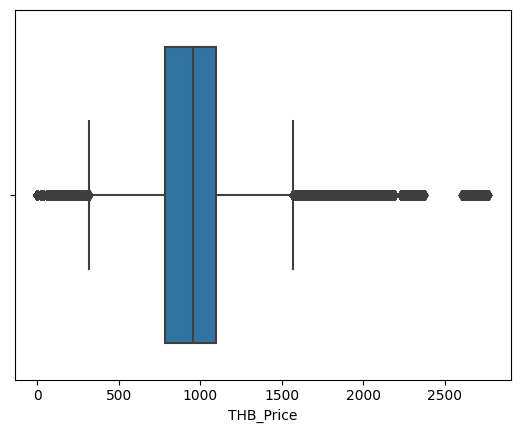

In [31]:
sns.boxplot(x = df_pd['THB_Price'])

<Axes: xlabel='THB_Price', ylabel='Count'>

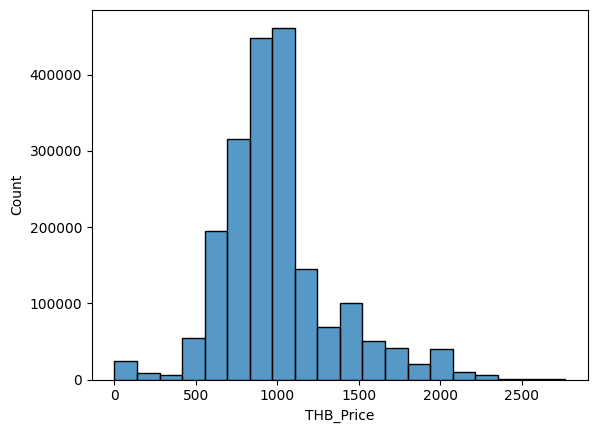

In [32]:
# bins : the number of bar that you want to show

sns.histplot(df_pd['THB_Price'], bins=20)

In [33]:
# Plotly - interactive chart ( Not recommend if your data is BIG )

# import plotly.express as px

# fig = px.scatter(df_pd, 'book_id', 'THB_Price')
# fig.show()

# DATA Cleaning

In [5]:
df.dropDuplicates()

DataFrame[timestamp: string, user_id: string, book_id: int, rating: string, rating_counts: double, categories: string, audio_runtime: string, audiobook_type: string, country: string, Price: double, THB_Price: double]

In [6]:
# convert string to datetime

df = df.withColumn("timestamp",
                        F.to_timestamp(df.timestamp, 'yyyy-MM-dd HH:mm:ss')
                        )
df.dtypes

[('timestamp', 'timestamp'),
 ('user_id', 'string'),
 ('book_id', 'int'),
 ('rating', 'string'),
 ('rating_counts', 'double'),
 ('categories', 'string'),
 ('audio_runtime', 'string'),
 ('audiobook_type', 'string'),
 ('country', 'string'),
 ('Price', 'double'),
 ('THB_Price', 'double')]

In [15]:
# Try counting the transactions for the back-half of June.

df.where( (F.dayofmonth(df.timestamp) <= 15) & ( F.month(df.timestamp) == 6 ) ).count()

326077

In [36]:
df.where(df['rating'] == 'Not rated yet').show()

+-------------------+--------+-------+-------------+-------------+----------+------------------+--------------+--------------------+-----+------------------+
|          timestamp| user_id|book_id|       rating|rating_counts|categories|     audio_runtime|audiobook_type|             country|Price|         THB_Price|
+-------------------+--------+-------+-------------+-------------+----------+------------------+--------------+--------------------+-----+------------------+
|2021-05-01 00:47:04|e9410570|    256|Not rated yet|         null|      null|            12 hrs|          null|United States of ...|30.79|          958.8006|
|2021-05-01 01:32:01|6cf1f6fd|   1127|Not rated yet|         null|      null|24 hrs and 30 mins|          null|               Spain| 49.0|1525.8600000000001|
|2021-05-01 01:47:11|b109259f|   1144|Not rated yet|         null|      null|             9 hrs|          null|               Egypt| 28.0| 871.9200000000001|
|2021-05-01 02:19:21|dc4915a5|   1147|Not rated yet|

In [37]:
df.where(df['rating'] == 'Not rated yet').count()

3621

## Fill missing data

In [7]:
diz = { "Not rated yet": '0', "4 out of 5 stars": '4', "4.5 out of 5 stars": '4.5', "5 out of 5 stars": '5' }

# diz = {k:str(v) for k,v in diz.items()}
# print(diz)

In [8]:
df = df.replace(diz,1,"rating")
df = df.withColumn("rating_update", F.when(df['rating'].isNull(), '0').otherwise(df['rating']))

# Check the result

df.select('rating_update').distinct().show(n=100, truncate=False, vertical=False)

/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:2213: UserWarning: to_replace is a dict and value is not None. value will be ignored.
  warnings.warn("to_replace is a dict and value is not None. value will be ignored.")


+-------------+
|rating_update|
+-------------+
|3.1          |
|4.2          |
|3            |
|4.4          |
|3.8          |
|2.7          |
|2.9          |
|4.5          |
|0            |
|2.5          |
|4.9          |
|3.4          |
|5            |
|3.3          |
|1.8          |
|4.3          |
|3.5          |
|4.8          |
|4.1          |
|4.6          |
|3.6          |
|1.5          |
|2.8          |
|3.2          |
|2.2          |
|1            |
|3.7          |
|4.7          |
|4            |
|2.3          |
|3.9          |
+-------------+



In [10]:
# replace rating_update to rating

df = df.drop("rating").withColumnRenamed('rating_update', 'rating')

In [9]:
# Now repeat the step above to other columns

df = df.withColumn("rating_count_update", F.when(df['rating_counts'].isNull(), '0').otherwise(df['rating_counts']))
df = df.drop("rating_counts").withColumnRenamed('rating_count_update', 'rating_counts')

df = df.withColumn("categories_update", F.when(df['categories'].isNull(), 'XX').otherwise(df['categories']))
df = df.drop("categories").withColumnRenamed('categories_update', 'categories')

df = df.withColumn("audiobook_type_update", F.when(df['audiobook_type'].isNull(), 'XX').otherwise(df['audiobook_type']))
df = df.drop("audiobook_type").withColumnRenamed('audiobook_type_update', 'audiobook_type')

In [11]:
df.dtypes

[('timestamp', 'timestamp'),
 ('user_id', 'string'),
 ('book_id', 'int'),
 ('audio_runtime', 'string'),
 ('country', 'string'),
 ('Price', 'double'),
 ('THB_Price', 'double'),
 ('rating', 'string'),
 ('rating_counts', 'string'),
 ('categories', 'string'),
 ('audiobook_type', 'string')]

In [12]:
# convert 'rating', 'string' to 'rating', 'double(float)'

df = df.withColumn("rating",df.rating.cast('double'))
df = df.withColumn("rating_counts",df.rating.cast('int'))

df.dtypes

[('timestamp', 'timestamp'),
 ('user_id', 'string'),
 ('book_id', 'int'),
 ('audio_runtime', 'string'),
 ('country', 'string'),
 ('Price', 'double'),
 ('THB_Price', 'double'),
 ('rating', 'double'),
 ('rating_counts', 'int'),
 ('categories', 'string'),
 ('audiobook_type', 'string')]

In [13]:
# Check missing value

df.select([ F.sum(F.col(colname).isNull().cast("int")).alias(colname) for colname in df.columns ]).show()

+---------+-------+-------+-------------+-------+-----+---------+------+-------------+----------+--------------+
|timestamp|user_id|book_id|audio_runtime|country|Price|THB_Price|rating|rating_counts|categories|audiobook_type|
+---------+-------+-------+-------------+-------+-----+---------+------+-------------+----------+--------------+
|        0|      0|      0|            0|      0|    0|        0|     0|            0|         0|             0|
+---------+-------+-------+-------------+-------+-----+---------+------+-------------+----------+--------------+



# ANOMALY Detection


In [14]:
df.where(df["user_id"].rlike("^[a-z0-9]{8}$")).count()

1998821

In [15]:
anm = df.where(df["user_id"].rlike("^[a-z0-9]{8}$"))
df_anormal = df.subtract(anm)

df_anormal.show()

+---------+-------+-------+-------------+-------+-----+---------+------+-------------+----------+--------------+
|timestamp|user_id|book_id|audio_runtime|country|Price|THB_Price|rating|rating_counts|categories|audiobook_type|
+---------+-------+-------+-------------+-------+-----+---------+------+-------------+----------+--------------+
+---------+-------+-------+-------------+-------+-----+---------+------+-------------+----------+--------------+



## Finding outliers
- From the exploratory data analysis (EDA), we have observed outliers in the price data.

<Axes: xlabel='Price'>

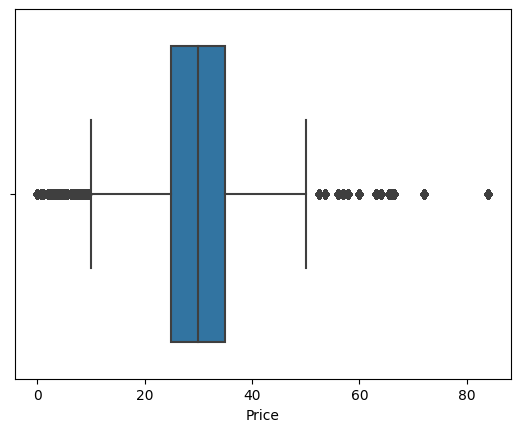

In [21]:
sns.boxplot(x = df_pd['Price'])

In [22]:
q = df_pd["Price"].quantile(0.99)

df.where( df.Price > q ).select("book_id").distinct().show()

+-------+
|book_id|
+-------+
|    737|
|    631|
|   1380|
|   1410|
|    646|
|   1831|
|    635|
+-------+



In this case, we checked the outlier by searching for *book_id: 635* (for example) from the [source](https://www.audible.com/pd/The-Power-Broker-Audiobook/B0051JH67K?ipRedirectOverride=true&overrideBaseCountry=true&pf_rd_p=2756bc30-e1e4-4174-bb22-bce00b971761&pf_rd_r=MF7KC1JQF3A6GK2ET8XM), and we confirmed that the data is correct. Therefore, we will take no action.

# Clean data with Spark SQL

In [ ]:
# Convert the Spark DataFrame to a TempView first.
# and then you can query by SQL command

df.createOrReplaceTempView("data")

df_sql = spark.sql("SELECT * FROM data")
df_sql.show()

In [ ]:
df_sql_country = spark.sql(
    """
    SELECT distinct country
    FROM data
    ORDER BY country
    """
    )
df_sql_country.show(20)

In [ ]:
df_sql_country = spark.sql(
    """
    SELECT *
    FROM data
    WHERE user_id NOT RLIKE '^[a-z0-9]{8}$'
    """
    )
df_sql_country.show(20)

# Export

In [ ]:
# This method will save in folder and have partition inside

# df.write.csv('/content/drive/MyDrive/myColab_Notebooks/Cleaned_data.csv', header = True)

In [23]:
# If you want to save in one file use this

df.coalesce(1).write.csv('/content/drive/MyDrive/myColab_Notebooks/Cleaned_Data_Single.csv', header = True)

- Results

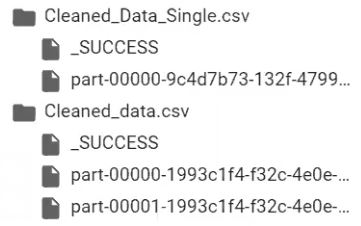

## How do I read them
when there are several files?

In [ ]:
readData = spark.read.csv('/content/drive/MyDrive/myColab_Notebooks/Cleaned_Data_Single.csv/part-*.csv', header = True, inferSchema = True)

In [ ]:
# check the row

readData.count()